In [1]:
import numpy as np
import h5py, os, cv2
import matplotlib.pyplot as plt

### Use Happy House Dataset (kaggle)
(https://www.kaggle.com/iarunava/happy-house-dataset/home)

### Preprocessing

In [2]:
base_path = 'Model/happy-house-dataset'

train_data = h5py.File(os.path.join(base_path, 'train_happy.h5'), 'r')
x_train = np.array(train_data['train_set_x'][:])
y_train = np.array(train_data['train_set_y'][:])

test_data = h5py.File(os.path.join(base_path, 'test_happy.h5'), 'r')
x_test = np.array(test_data['test_set_x'][:])
y_test = np.array(test_data['test_set_y'][:])

y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

np.save(os.path.join(base_path, 'x_train_color.npy'), x_train)
np.save(os.path.join(base_path, 'x_test_color.npy'), x_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(600, 64, 64, 3) (600, 1)
(150, 64, 64, 3) (150, 1)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


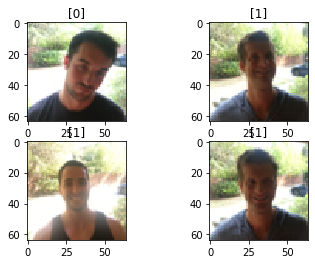

In [3]:
plt.subplot(2, 2, 1)
plt.title(y_train[0])
plt.imshow(x_train[0])
plt.subplot(2, 2, 2)
plt.title(y_train[1])
plt.imshow(x_train[1])
plt.subplot(2, 2, 3)
plt.title(y_test[0])
plt.imshow(x_test[0])
plt.subplot(2, 2, 4)
plt.title(y_test[1])
plt.imshow(x_test[1])

In [4]:
x_result = []
for x in x_train:
    img = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
    x_result.append(img)

x_result = np.array(x_result)
np.save(os.path.join(base_path, 'x_train.npy'), x_result)

x_result = []
for x in x_test:
    img = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
    x_result.append(img)

x_result = np.array(x_result)
np.save(os.path.join(base_path, 'x_test.npy'), x_result)

np.save(os.path.join(base_path, 'y_train.npy'), y_train)
np.save(os.path.join(base_path, 'y_test.npy'), y_test)

### Smile detection use CNN

In [5]:
import numpy as np
import os, h5py
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, Input, MaxPooling2D, Activation, LeakyReLU, Flatten, Dropout
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

### Preview

(600, 64, 64) (600, 1)
(150, 64, 64) (150, 1)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


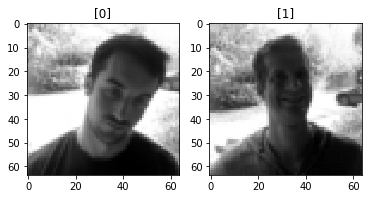

In [6]:
base_path = 'Model/happy-house-dataset'

x_train = np.load(os.path.join(base_path, 'x_train.npy'))
y_train = np.load(os.path.join(base_path, 'y_train.npy'))
x_test = np.load(os.path.join(base_path, 'x_test.npy'))
y_test = np.load(os.path.join(base_path, 'y_test.npy'))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

plt.subplot(1, 2, 1)
plt.title(y_train[0])
plt.imshow(x_train[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.title(y_train[1])
plt.imshow(x_train[1], cmap='gray')

### Data Augmentation

In [7]:
x_train = x_train.reshape((-1, 64, 64, 1))
x_test = x_test.reshape((-1, 64, 64, 1))

train_datagen = ImageDataGenerator(
    samplewise_center=True, # 각 이미지의 평균을 0으로 설정. (Boolean. Set each sample mean to 0.)
    samplewise_std_normalization=True, # 각 이미지의 표준편차로 나눔. (Boolean. Divide each input by its std.)
    brightness_range=[0.5, 1.5],
    zoom_range=[0.8, 1.1],
    rotation_range=15.,
    channel_shift_range=25,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
)

train_batch_gen = train_datagen.flow(x_train, y_train, batch_size=16, shuffle=True) # flow method_x데이터와 y데이터를 배치단위로 생성할 수 있게 만듦.
test_batch_gen = test_datagen.flow(x_test, y_test, batch_size=16, shuffle=False)

### Make a model

In [8]:
inputs = Input(shape=(64, 64, 1))

net = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(inputs)
net = LeakyReLU()(net)

net = Flatten()(net)

net = Dense(units=64)(net)
net = Activation('relu')(net)

net = Dense(units=1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4194368   
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_______________________________

In [9]:
model.fit_generator(
    train_batch_gen,
    epochs=20,
    validation_data=test_batch_gen,
    callbacks=[
        ModelCheckpoint(os.path.join(base_path, 'happy.h5'), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=1, mode='auto', min_lr=1e-05)
    ]
)


Epoch 1/20
38/38 [==============================] - 2s 43ms/step - loss: 0.9593 - acc: 0.6067 - val_loss: 0.5603 - val_acc: 0.6400

Epoch 00001: val_acc improved from -inf to 0.64000, saving model to Model/happy-house-dataset/happy.h5
Epoch 2/20
38/38 [==============================] - 1s 37ms/step - loss: 0.5807 - acc: 0.7150 - val_loss: 0.4765 - val_acc: 0.7400

Epoch 00002: val_acc improved from 0.64000 to 0.74000, saving model to Model/happy-house-dataset/happy.h5
Epoch 3/20
38/38 [==============================] - 2s 40ms/step - loss: 0.5923 - acc: 0.6933 - val_loss: 0.4517 - val_acc: 0.7533

Epoch 00003: val_acc improved from 0.74000 to 0.75333, saving model to Model/happy-house-dataset/happy.h5
Epoch 4/20
38/38 [==============================] - 2s 44ms/step - loss: 0.5395 - acc: 0.7200 - val_loss: 0.4125 - val_acc: 0.7267

Epoch 00004: val_acc did not improve from 0.75333
Epoch 5/20
38/38 [==============================] - 2s 40ms/step - loss: 0.5112 - acc: 0.7300 - val_loss: 

In [10]:
x_test_input = x_test.copy().astype(np.float64)
x_test_input -= np.mean(x_test, keepdims=True)
x_test_input /= (np.std(x_test, keepdims=True) + 1e-6)

y_pred = model.predict(x_test_input)

y_pred_logical = (y_pred > 0.5).astype(np.int) # 0.5를 기준으로 작으면 웃지 않음으로 판단.

### Confusion Matrix

test acc: 0.9066666666666666


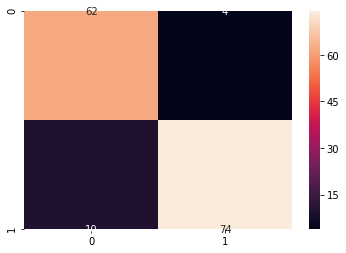

In [11]:
print ('test acc: %s' % accuracy_score(y_test, y_pred_logical))

cm = confusion_matrix(y_test, y_pred_logical)
sns.heatmap(cm, annot=True)